In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
N = 2500
L = 250
x = np.linspace(-20, L, N+1)
dx = x[1] - x[0]
a = 40
V0 = 40

In [3]:
def integral(f, dx):
    return np.sum(f*dx, axis=0)

def gaussian_packet(sigma=5, x0=90, k0=-1):
    psi_0 = np.exp(-(x[1:-1] - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x[1:-1])
    norm  = integral(np.abs(psi_0)**2, dx)
    return psi_0 / np.sqrt(norm)

def hamiltonian(V0=40):
    T = -1 / (2 * dx**2) * (np.diag(-2*np.ones(N-1)) + np.diag(np.ones(N-2),1) + np.diag(np.ones(N-2),-1))
    V_flat = np.array([0 if pos < a else V0/pos for pos in x[1:-1]])
    V = np.diag(V_flat)
    H = T + V
    return H, V_flat

def get_eigenstates(H):
    En, eigenstates = np.linalg.eigh(H)
    eigenstates = eigenstates.T
    norm = integral(np.abs(eigenstates)**2, dx)
    eigenstates_list = eigenstates / np.sqrt(norm)
    eigenstates_matrix = eigenstates_list.T
    return En, eigenstates_list, eigenstates_matrix

def get_coeffs_in_basis(psi, basis_list):
    coeffs = np.zeros_like(basis_list[0], dtype=complex)
    for j in range(0, len(basis_list)):
        coeffs[j] = integral(np.conj(basis_list[j]) * psi, dx)
    return coeffs

In [4]:
H, V_flat = hamiltonian(V0=V0)

En, eigenstates_list, eigenstates_matrix = get_eigenstates(H)

timespan = np.linspace(0, 100, 100)
dt = timespan[1] - timespan[0]

In [5]:
energies = []
transmissions = []
for k in [-0.2, -0.4, -0.6, -0.8, -1]:
    print(k)
    for x0 in range(60, 110, 5):
        psi_0 = gaussian_packet(sigma=5, x0=x0, k0=k)
        coeff_0 = get_coeffs_in_basis(psi_0, eigenstates_list)

        E = np.sum(En * np.abs(coeff_0)**2)
        transmission = 0
        for t in timespan:
            c_n = coeff_0 * np.exp(-1j * En * t)
            psi = eigenstates_matrix @ (c_n)
            tunnelled_fraction = integral(np.abs(psi[x[1:-1] < a])**2, dx)
            transmission = np.max([transmission, tunnelled_fraction])
        energies.append(E)
        transmissions.append(transmission)


-0.2
-0.4
-0.6
-0.8
-1


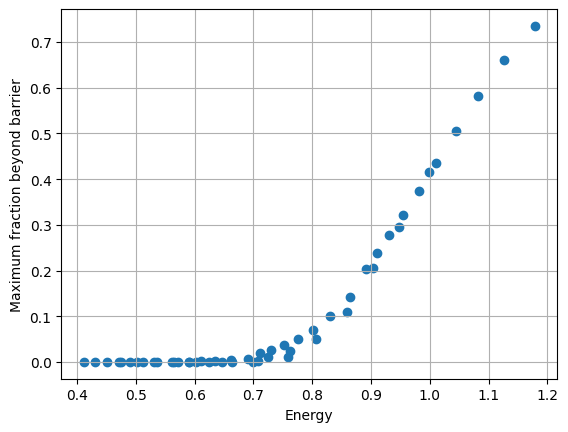

In [6]:
energies = np.array(energies)
transmissions = np.array(transmissions)
plt.scatter(energies, transmissions)
plt.xlabel('Energy')
plt.ylabel('Maximum fraction beyond barrier')
plt.grid()
plt.show()

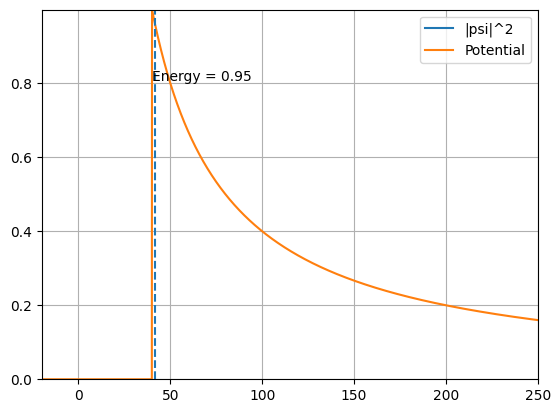

In [7]:
psi_0 = gaussian_packet(sigma=5, x0=90, k0=-1)
coeff_0 = get_coeffs_in_basis(psi_0, eigenstates_list)

E = np.sum(En * np.abs(coeff_0)**2)
classical_limit = V0 / E

fig, ax = plt.subplots()
line, = ax.plot([], [], label="|psi|^2")
potential_line, = ax.plot(x[1:-1], V_flat, label="Potential")
energy_text = ax.text(a, V0 / a * 0.8, f'Energy = {E:.2f}', ha='left', va='bottom')
tunnel_text = ax.text(a, V0 / a * 0.9, '', ha='left', va='bottom')
ax.vlines(classical_limit, 0, V0, linestyles='dashed')
ax.grid()
ax.set_xlim(x.min(), x.max())
ax.set_ylim(np.min(V_flat), max(np.max(V_flat),1.1*np.max(np.abs(eigenstates_matrix)**2)))
ax.legend()

def animate(i):
    t = timespan[i]
    c_n = coeff_0 * np.exp(-1j * En * t)
    psi = eigenstates_matrix @ (c_n)
    tunnelled_fraction = integral(np.abs(psi[x[1:-1] < a])**2, dx)
    psi_mod_sq = np.abs(psi)**2

    line.set_data(x[1:-1], psi_mod_sq)
    energy_text.set_text(f'Energy = {E:.2f}')
    tunnel_text.set_text(f'Tunnelled fraction: {tunnelled_fraction:.3f}')
    return line, energy_text, tunnel_text

In [8]:
ani = FuncAnimation(fig, animate, frames=len(timespan), blit=True, interval=10, repeat=False)

ani.save('animation.mp4', writer='ffmpeg', fps=60)

plt.close(fig)

from IPython.display import Video
Video("animation.mp4")

<video controls="true" width="600">
  <source src="animation.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>

In [14]:
e = 1.52e-14
rs = 1e-15
m = 8.36e-28
h = 1.06e-34
kT = 1.38e-23 * 1.6e7

energies = np.linspace(0.1, 100, 1000) * 1.6e-16 # 0.1 - 100 keV
prob = []

for j, E in enumerate(energies):
    r2 = e**2 / E
    x = np.linspace(rs, r2, 10**5)[:-1]
    i = integral(np.sqrt(2 * m * (e**2 / x - E)), x[1]-x[0])
    prob.append(np.exp(-2/h * i))

boltzmann = np.exp(-energies / kT)
gamow_curve = prob * boltzmann
gamow_peak = energies[np.argmax(gamow_curve)] / (1.6e-16)

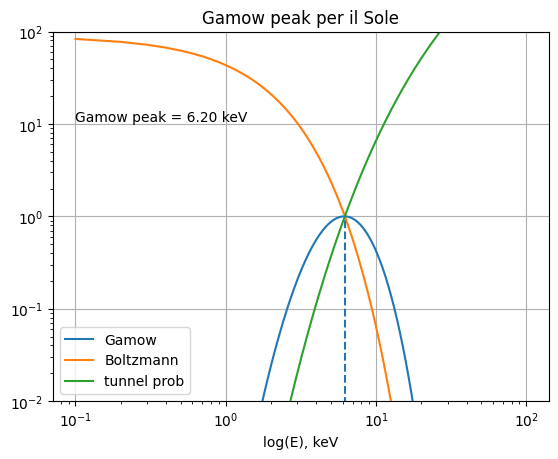

In [15]:
prob = prob / prob[np.argmax(gamow_curve)]
boltzmann = boltzmann / boltzmann[np.argmax(gamow_curve)]
gamow_curve = gamow_curve / np.max(gamow_curve)

gamow_curve[np.log10(gamow_curve) < -3] = 0
boltzmann[np.log10(boltzmann) < -3] = 0
prob[np.log10(prob) < -3] = 0

plt.plot(energies / (1.6e-16), gamow_curve, label='Gamow')
plt.plot(energies / (1.6e-16), boltzmann, label='Boltzmann')
plt.plot(energies / (1.6e-16), prob, label='tunnel prob')
plt.vlines(gamow_peak, 0, 1, linestyles='dashed')
plt.title('Gamow peak per il Sole')
plt.text(0.1, 10, f'Gamow peak = {gamow_peak:.2f} keV', ha='left', va='bottom')
plt.legend()
plt.grid()
plt.xlabel('log(E), keV')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.01, 10**2)
plt.show()
